### unet

In [ ]:
size_low_572 = 572

x_low_572= np.linspace(0, 2 * np.pi, size_low_572)
y_low_572 = np.linspace(0, 2 * np.pi, size_low_572)



X_low_572, Y_low_572 = np.meshgrid(x_low_572, y_low_572)


size_low_388 = 388

x_low_388= np.linspace(0, 2 * np.pi, size_low_388)
y_low_388 = np.linspace(0, 2 * np.pi, size_low_388)



X_low_388, Y_low_388 = np.meshgrid(x_low_388, y_low_388)


In [ ]:
A_low_527 = a(X_low_572, Y_low_572)
B_low_527 = b(X_low_572, Y_low_572)
C_low_527 = c(X_low_572, Y_low_572)
D_low_527 = d(X_low_572, Y_low_572)

dx_low_572 = x_low_572[1] - x_low_572[0]
dy_low_572 = y_low_572[1] - y_low_572[0]

U_x_low_572, U_y_low_572 = compute_velocity_field_np(X_low_572, Y_low_572, dx_low_572, dy_low_572)

U_magnitude_low_572 = np.sqrt(U_x_low_572**2 + U_y_low_572**2)



A_low_388 = a(X_low_388, Y_low_388)
B_low_388 = b(X_low_388, Y_low_388)
C_low_388 = c(X_low_388, Y_low_388)
D_low_388 = d(X_low_388, Y_low_388)

dx_low_388 = x_low_388[1] - x_low_388[0]
dy_low_388 = y_low_388[1] - y_low_388[0]

U_x_low_388, U_y_low_388 = compute_velocity_field_np(X_low_388, Y_low_388, dx_low_388, dy_low_388)

U_magnitude_low_388 = np.sqrt(U_x_low_388**2 + U_y_low_388**2)



In [ ]:
A_low_388_tensor = torch.tensor(A_low_388, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
B_low_388_tensor = torch.tensor(B_low_388, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
C_low_388_tensor = torch.tensor(C_low_388, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
D_low_388_tensor = torch.tensor(D_low_388, dtype=torch.float32).unsqueeze(0).unsqueeze(0)


In [ ]:
# 将数据转换为PyTorch张量
U_x_572 = torch.tensor(U_x_low_572, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # 增加batch和channel维度
U_y_572 = torch.tensor(U_y_low_572, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_magnitude_572 = torch.tensor(U_magnitude_low_572, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# 合并速度场作为输入
velocity_field = torch.cat((U_x_572, U_y_572, U_magnitude_572), dim=1)

# 目标abcd (假设为0初始化)
target_abcd_572 = torch.zeros((1, 4, size_low_572, size_low_572), dtype=torch.float32)

# 创建数据集和数据加载器
# dataset = TensorDataset(velocity_field, target_abcd)
# dataloader = DataLoader(dataset, batch_size=500, shuffle=True)


u_x_388 = torch.tensor(U_x_low_388, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # 增加batch和channel维度
u_y_388 = torch.tensor(U_y_low_388, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
u_magnitude_388 = torch.tensor(U_magnitude_low_388, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

u_magnitude_388.shape

torch.Size([1, 1, 388, 388])

In [ ]:
# 定义损失函数
# 这个 loss function 考虑了数学和物理约束
def loss_function_unet(predicted_abcd, true_velocity, epsilon):
    # 提取 a, b, c, d
    # 提取 a, b, c, d，并增加批次维度以兼容梯度计算
    a = predicted_abcd[:, 0, :, :]
    b = predicted_abcd[:, 1, :, :]
    c = predicted_abcd[:, 2, :, :]
    d = predicted_abcd[:, 3, :, :]
    # print(a.shape)
    
    # 计算梯度
    a_grad_x, a_grad_y = calculate_gradients_with_numpy(a)
    b_grad_x, b_grad_y = calculate_gradients_with_numpy(b)
    c_grad_x, c_grad_y = calculate_gradients_with_numpy(c)
    d_grad_x, d_grad_y = calculate_gradients_with_numpy(d)

    hbar = 1  # 你可以根据具体情况调整这个参数


    # # 根据 a, b, c, d 计算预测的速度场
    # U_x_pred = a + b
    # U_y_pred = c + d
    # U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)
    
    # # 计算速度场的损失
    # U_x_true = true_velocity[:, 0, :, :]
    # U_y_true = true_velocity[:, 1, :, :]
    # U_magnitude_true = true_velocity[:, 2, :, :]


    U_x_pred = hbar * (a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x)
    U_y_pred = hbar * (a * b_grad_y - b * a_grad_y + c * d_grad_y - d * c_grad_y)
    U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)
    
    # # 计算速度场的损失
    U_x_true = u_x_388
    U_y_true = u_y_388
    U_magnitude_true = u_magnitude_388
    # print(U_magnitude_pred.shape,U_magnitude_true.shape)
    


    loss_velocity =  F.mse_loss(U_magnitude_pred, U_magnitude_true[:,0,:,:])#+F.mse_loss(U_x_pred, U_x_true[:,0,:,:]) + F.mse_loss(U_y_pred, U_y_true[:,0,:,:]) 
    
    # 计算归一化约束
    # psi1 = a + 1j * b
    # psi2 = c + 1j * d
    norm = a**2 + b**2 + c**2 + d**2

    
    norm_constraint = F.mse_loss(norm, torch.ones_like(norm))
    
    #     # 计算拉普拉斯算子
    lap_b = laplacian_2d_torch(b, dx_low,dy_low)
    lap_a = laplacian_2d_torch(a, dx_low,dy_low)
    lap_d = laplacian_2d_torch(d, dx_low,dy_low)
    lap_c = laplacian_2d_torch(c, dx_low,dy_low)

    # 计算 abcd的约束
    a_loss = F.mse_loss(a, A_low_388_tensor[:,0,:,:])
    b_loss = F.mse_loss(b, B_low_388_tensor[:,0,:,:])
    c_loss = F.mse_loss(c, C_low_388_tensor[:,0,:,:])
    d_loss = F.mse_loss(d, D_low_388_tensor[:,0,:,:])

    loss_abcd = a_loss + b_loss + c_loss + d_loss


    # # 计算螺旋度约束

    curl_constraint = (a * lap_b - b * lap_a + c * lap_d - d * lap_c).sum()
    
    # # 计算正则化项
    regularization_term = epsilon * 0.25*(torch.sum(a**2) + torch.sum(b**2) + torch.sum(c**2) + torch.sum(d**2))
    
    # # 总损失
    total_loss =  regularization_term
    total_loss += 1*loss_velocity
    # total_loss += 0.8*loss_abcd
    # total_loss += norm_constraint
    # total_loss += curl_constraint   
    return total_loss

In [ ]:
A_low_388_tensor.shape

torch.Size([1, 1, 388, 388])

In [ ]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0)  # 输入通道数改为3
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.relu1_2 = nn.ReLU(inplace=True)

        self.maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.relu2_2 = nn.ReLU(inplace=True)

        self.maxpool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
        self.relu3_2 = nn.ReLU(inplace=True)

        self.maxpool_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=0)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0)
        self.relu4_2 = nn.ReLU(inplace=True)

        self.maxpool_4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=0)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=0)
        self.relu5_2 = nn.ReLU(inplace=True)

        self.up_conv_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0)

        self.conv6_1 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=0)
        self.relu6_1 = nn.ReLU(inplace=True)
        self.conv6_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0)
        self.relu6_2 = nn.ReLU(inplace=True)

        self.up_conv_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0)

        self.conv7_1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=0)
        self.relu7_1 = nn.ReLU(inplace=True)
        self.conv7_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
        self.relu7_2 = nn.ReLU(inplace=True)

        self.up_conv_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0)

        self.conv8_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.relu8_1 = nn.ReLU(inplace=True)
        self.conv8_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.relu8_2 = nn.ReLU(inplace=True)

        self.up_conv_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0)

        self.conv9_1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu9_1 = nn.ReLU(inplace=True)
        self.conv9_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.relu9_2 = nn.ReLU(inplace=True)

        self.conv_10 = nn.Conv2d(in_channels=64, out_channels=4, kernel_size=1, stride=1, padding=0)  # 输出通道数改为4

    def crop_tensor(self, tensor, target_tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]

    def forward(self, x):
        x1 = self.conv1_1(x)
        x1 = self.relu1_1(x1)
        x2 = self.conv1_2(x1)
        x2 = self.relu1_2(x2)
        down1 = self.maxpool_1(x2)

        x3 = self.conv2_1(down1)
        x3 = self.relu2_1(x3)
        x4 = self.conv2_2(x3)
        x4 = self.relu2_2(x4)
        down2 = self.maxpool_2(x4)

        x5 = self.conv3_1(down2)
        x5 = self.relu3_1(x5)
        x6 = self.conv3_2(x5)
        x6 = self.relu3_2(x6)
        down3 = self.maxpool_3(x6)

        x7 = self.conv4_1(down3)
        x7 = self.relu4_1(x7)
        x8 = self.conv4_2(x7)
        x8 = self.relu4_2(x8)
        down4 = self.maxpool_4(x8)

        x9 = self.conv5_1(down4)
        x9 = self.relu5_1(x9)
        x10 = self.conv5_2(x9)
        x10 = self.relu5_2(x10)

        up1 = self.up_conv_1(x10)
        crop1 = self.crop_tensor(x8, up1)
        up_1 = torch.cat([crop1, up1], dim=1)

        y1 = self.conv6_1(up_1)
        y1 = self.relu6_1(y1)
        y2 = self.conv6_2(y1)
        y2 = self.relu6_2(y2)

        up2 = self.up_conv_2(y2)
        crop2 = self.crop_tensor(x6, up2)
        up_2 = torch.cat([crop2, up2], dim=1)

        y3 = self.conv7_1(up_2)
        y3 = self.relu7_1(y3)
        y4 = self.conv7_2(y3)
        y4 = self.relu7_2(y4)

        up3 = self.up_conv_3(y4)
        crop3 = self.crop_tensor(x4, up3)
        up_3 = torch.cat([crop3, up3], dim=1)

        y5 = self.conv8_1(up_3)
        y5 = self.relu8_1(y5)
        y6 = self.conv8_2(y5)
        y6 = self.relu8_2(y6)

        up4 = self.up_conv_4(y6)
        crop4 = self.crop_tensor(x2, up4)
        up_4 = torch.cat([crop4, up4], dim=1)

        y7 = self.conv9_1(up_4)
        y7 = self.relu9_1(y7)
        y8 = self.conv9_2(y7)
        y8 = self.relu9_2(y8)

        out = self.conv_10(y8)
        return out

In [ ]:
num_epochs = 1000
learning_rate=0.001

In [ ]:
# 创建Unet模型实例
unet = Unet()
optimizer = optim.Adam(unet.parameters(), lr=learning_rate)



for epoch in range(num_epochs):
    epsilon = initial_epsilon * ((final_epsilon / initial_epsilon) ** (epoch / num_epochs))
    for i, (velocity, _) in enumerate(dataloader):
        optimizer.zero_grad()
        # 使用已经实例化的unet对象来调用模型
        predicted_abcd_unet = unet(velocity_field)
        loss = loss_function_unet(predicted_abcd_unet, velocity, epsilon)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')


Epoch [1/1000], Step [1], Loss: 6.3713
Epoch [2/1000], Step [1], Loss: 1.3528
Epoch [3/1000], Step [1], Loss: 3.4356
Epoch [4/1000], Step [1], Loss: 0.7323
Epoch [5/1000], Step [1], Loss: 1.1680
Epoch [6/1000], Step [1], Loss: 1.3838
Epoch [7/1000], Step [1], Loss: 1.2418
Epoch [8/1000], Step [1], Loss: 0.9840
Epoch [9/1000], Step [1], Loss: 3.7025
Epoch [10/1000], Step [1], Loss: 0.6802
Epoch [11/1000], Step [1], Loss: 0.6867
Epoch [12/1000], Step [1], Loss: 0.6992
Epoch [13/1000], Step [1], Loss: 0.6680
Epoch [14/1000], Step [1], Loss: 0.6432
Epoch [15/1000], Step [1], Loss: 0.6446
Epoch [16/1000], Step [1], Loss: 0.6455
Epoch [17/1000], Step [1], Loss: 0.6045
Epoch [18/1000], Step [1], Loss: 0.5613
Epoch [19/1000], Step [1], Loss: 0.5458
Epoch [20/1000], Step [1], Loss: 0.5821
Epoch [21/1000], Step [1], Loss: 0.5495
Epoch [22/1000], Step [1], Loss: 0.5369
Epoch [23/1000], Step [1], Loss: 0.5239
Epoch [24/1000], Step [1], Loss: 0.5141
Epoch [25/1000], Step [1], Loss: 0.5109
Epoch [26

In [ ]:
a_unet = predicted_abcd_unet[:, 0, :, :].squeeze().detach().numpy()
b_unet = predicted_abcd_unet[:, 1, :, :].squeeze().detach().numpy()
c_unet = predicted_abcd_unet[:, 2, :, :].squeeze().detach().numpy()
d_unet = predicted_abcd_unet[:, 3, :, :].squeeze().detach().numpy()



In [ ]:
a_unet.shape

(388, 388)

In [ ]:
a_unet_grad_x, a_unet_grad_y = np.gradient(a_unet, dx_low_388)
b_unet_grad_x, b_unet_grad_y = np.gradient(b_unet, dx_low_388)
c_unet_grad_x, c_unet_grad_y = np.gradient(c_unet, dx_low_388)
d_unet_grad_x, d_unet_grad_y = np.gradient(d_unet, dx_low_388)


U_x_unet = a_unet * b_unet_grad_x - b_unet * a_unet_grad_x + c_unet * d_unet_grad_x - d_unet * c_unet_grad_x
U_y_unet = a_unet * b_unet_grad_y - b_unet * a_unet_grad_y + c_unet * d_unet_grad_y - d_unet * c_unet_grad_y

U_magnitude_unet = np.sqrt(U_x_unet**2 + U_y_unet**2)


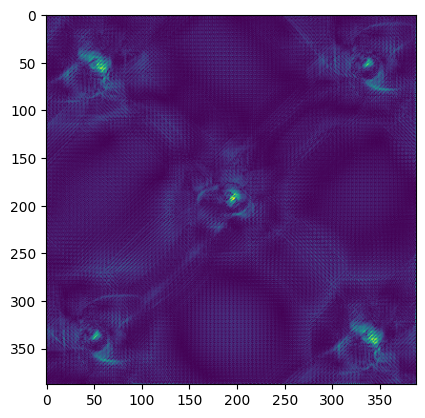

In [ ]:
plt.imshow(U_magnitude_unet)

In [ ]:
a_test = predicted_abcd_test[:, 0, :, :].squeeze().numpy()
b_test = predicted_abcd_test[:, 1, :, :].squeeze().numpy()
c_test = predicted_abcd_test[:, 2, :, :].squeeze().numpy()
d_test = predicted_abcd_test[:, 3, :, :].squeeze().numpy()


a_test_grad_x, a_test_grad_y = np.gradient(a_test, dx_low)
b_test_grad_x, b_test_grad_y = np.gradient(b_test, dx_low)
c_test_grad_x, c_test_grad_y = np.gradient(c_test, dx_low)
d_test_grad_x, d_test_grad_y = np.gradient(d_test, dx_low)

U_x_pred_test = a_test * b_test_grad_x - b_test * a_test_grad_x + c_test * d_test_grad_x - d_test * c_test_grad_x
U_y_pred_test = a_test * b_test_grad_y - b_test * a_test_grad_y + c_test * d_test_grad_y - d_test * c_test_grad_y
U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)

In [ ]:
predicted_abcd_unet.shape

torch.Size([1, 4, 388, 388])

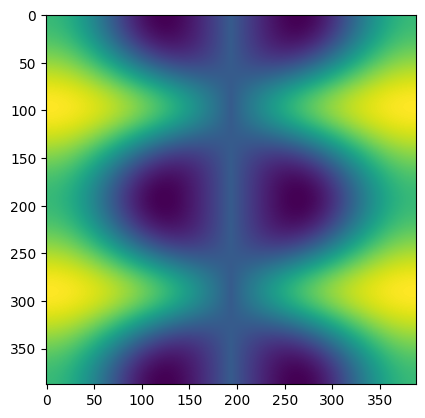

In [ ]:
plt.imshow(A_low_388)

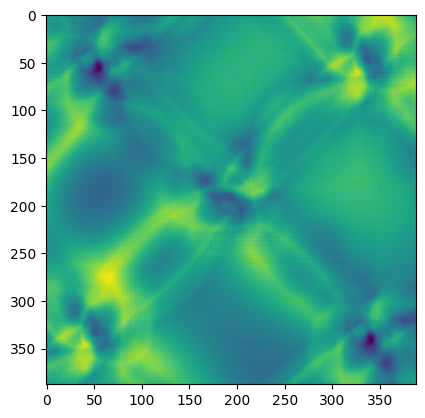

In [ ]:
plt.imshow(predicted_abcd_unet[:, 0, :, :].squeeze().detach().numpy(), cmap='viridis')